In [1]:
!pip install cloudscraper

In [2]:
URL = "https://services.gingersoftware.com/Ginger/correct/jsonSecured/GingerTheTextFull"  # noqa
API_KEY = "6ae0c3a0-afdc-4532-a810-82ded0054236"
class GingerIt(object):
    def __init__(self):
        self.url = URL
        self.api_key = API_KEY
        self.api_version = "2.0"
        self.lang = "US"

    def parse(self, text, verify=True):
        session = cloudscraper.create_scraper()
        request = session.get(
            self.url,
            params={
                "lang": self.lang,
                "apiKey": self.api_key,
                "clientVersion": self.api_version,
                "text": text,
            },
            verify=verify,
        )
        data = request.json()
        return self._process_data(text, data)

    @staticmethod
    def _change_char(original_text, from_position, to_position, change_with):
        return "{}{}{}".format(
            original_text[:from_position], change_with, original_text[to_position + 1 :]
        )

    def _process_data(self, text, data):
        result = text
        corrections = []

        for suggestion in reversed(data["Corrections"]):
            start = suggestion["From"]
            end = suggestion["To"]

            if suggestion["Suggestions"]:
                suggest = suggestion["Suggestions"][0]
                result = self._change_char(result, start, end, suggest["Text"])

                corrections.append(
                    {
                        "start": start,
                        "text": text[start : end + 1],
                        "correct": suggest.get("Text", None),
                        "definition": suggest.get("Definition", None),
                    }
                )

        return {"text": text, "result": result, "corrections": corrections}

In [3]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re, os, logging, time, pickle, itertools, numpy as np
from collections import Counter

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

import requests, cloudscraper
from shutil import rmtree
from pathlib import Path
from re import findall

In [4]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"
stop_words = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 'can', 'will', 'just', 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain']
stemmer = SnowballStemmer("english")

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

In [5]:
path_to_source_folder = '/content/drive/MyDrive/Rohit/training.1600000.processed.noemoticon.csv.zip'
# model_out = Path('/content/drive/MyDrive/20frame_20classmodel')
# batch_size = 100
ACCURACY_THRESHOLD = 0.95
split_ratio = 0.2       #training validation split

In [6]:
make_dir = Path('/content/dataset')
if make_dir.exists(): rmtree(make_dir)
make_dir.mkdir()

if findall('.7z', str(path_to_source_folder)):
    with py7zr.SevenZipFile(path_to_source_folder, mode='r') as z:
        z.extractall('/content/dataset')
    path_to_source_folder = Path('/content/dataset')
elif findall('.zip', str(path_to_source_folder)):
    !unzip $path_to_source_folder -d /content/dataset
    path_to_source_folder = Path('/content/dataset/')
else:
    path_to_source_folder = Path(path_to_source_folder)

Archive:  /content/drive/MyDrive/Rohit/training.1600000.processed.noemoticon.csv.zip
  inflating: /content/dataset/training.1600000.processed.noemoticon.csv  


In [7]:
dataset_filename = os.listdir(path_to_source_folder)[0]
dataset_path = os.path.join(path_to_source_folder,dataset_filename)
print("Open file:", dataset_path)
df = pd.read_csv(dataset_path, encoding =DATASET_ENCODING , names=DATASET_COLUMNS)

Open file: /content/dataset/training.1600000.processed.noemoticon.csv


In [8]:
print("Dataset size:", len(df))
print(df.head(5))

Dataset size: 1600000
   target         ids                          date      flag  \
0       0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY   
1       0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   
2       0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY   
3       0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
4       0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   

              user                                               text  
0  _TheSpecialOne_  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1    scotthamilton  is upset that he can't update his Facebook by ...  
2         mattycus  @Kenichan I dived many times for the ball. Man...  
3          ElleCTF    my whole body feels itchy and like its on fire   
4           Karoli  @nationwideclass no, it's not behaving at all....  


In [9]:
decode_map = {0: 0, 4: 1}
df.target = df.target.apply(lambda x: decode_map[int(x)])

Text(0.5, 1.0, 'Dataset labels distribuition')

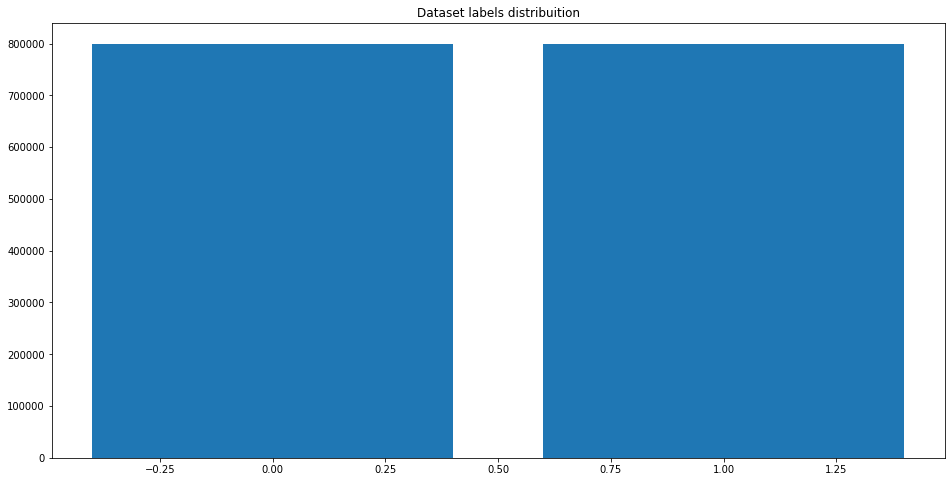

In [10]:
target_cnt = Counter(df.target)
plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

In [11]:
count  = 0
count1 = 0
for i in df['target']:
    if i == 0:
        count+=1
    elif i ==1:
        count1+=1
print(count, "  ", count1)

800000    800000


In [12]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    # print("Before gingerit  : ", text)
    # text = parser.parse(text)
    # corrections = text['corrections']
    # text = text['text']
    # print("Corrections      : ", corrections)
    # print("After gingerit   : ", text)
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    # print("After Stopwords and Stemmer : ", tokens)
    # print("------------------------------------------------------------------------------------------")
    pbar.update(1)
    return " ".join(tokens)

In [13]:
%%time
from tqdm import tqdm
# parser = GingerIt()
pbar = tqdm(total=len(df.text), bar_format ='{l_bar}{bar}|  {n_fmt}/{total_fmt}  [ Elapsed Time : {elapsed} | ETA : {remaining} ]', leave=True, position=0)
new_df= pd.DataFrame()
new_df.text = df.text.apply(lambda x: preprocess(x))

100%|█████████▉|  1597276/1600000  [ Elapsed Time : 01:12 | ETA : 00:00 ]

CPU times: user 1min 4s, sys: 702 ms, total: 1min 4s
Wall time: 1min 12s


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """


In [14]:
print(len(df.text))

1600000


In [15]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))


TRAIN size: 1280000
TEST size: 320000


In [16]:
%%time
documents = [_text.split() for _text in df_train.text]

CPU times: user 4.47 s, sys: 1.81 s, total: 6.27 s
Wall time: 6.29 s


In [17]:
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [18]:
w2v_model.build_vocab(documents)

2022-04-03 18:51:36,175 : INFO : collecting all words and their counts
2022-04-03 18:51:36,178 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2022-04-03 18:51:36,223 : INFO : PROGRESS: at sentence #10000, processed 132112 words, keeping 29901 word types
2022-04-03 18:51:36,265 : INFO : PROGRESS: at sentence #20000, processed 263673 words, keeping 51026 word types
2022-04-03 18:51:36,304 : INFO : PROGRESS: at sentence #30000, processed 393870 words, keeping 69231 word types
2022-04-03 18:51:36,352 : INFO : PROGRESS: at sentence #40000, processed 526649 words, keeping 86122 word types
2022-04-03 18:51:36,396 : INFO : PROGRESS: at sentence #50000, processed 657596 words, keeping 102097 word types
2022-04-03 18:51:36,441 : INFO : PROGRESS: at sentence #60000, processed 788578 words, keeping 117455 word types
2022-04-03 18:51:36,490 : INFO : PROGRESS: at sentence #70000, processed 919604 words, keeping 131952 word types
2022-04-03 18:51:36,536 : INFO : PROGRESS: 

In [19]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 59839


In [20]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

2022-04-03 18:51:56,258 : INFO : training model with 8 workers on 59839 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
2022-04-03 18:51:57,381 : INFO : EPOCH 1 - PROGRESS: at 2.44% examples, 272714 words/s, in_qsize 16, out_qsize 2
2022-04-03 18:51:58,448 : INFO : EPOCH 1 - PROGRESS: at 5.17% examples, 294024 words/s, in_qsize 15, out_qsize 0
2022-04-03 18:51:59,537 : INFO : EPOCH 1 - PROGRESS: at 7.90% examples, 299428 words/s, in_qsize 16, out_qsize 0
2022-04-03 18:52:00,573 : INFO : EPOCH 1 - PROGRESS: at 10.57% examples, 304045 words/s, in_qsize 16, out_qsize 0
2022-04-03 18:52:01,575 : INFO : EPOCH 1 - PROGRESS: at 13.36% examples, 311496 words/s, in_qsize 15, out_qsize 0
2022-04-03 18:52:02,583 : INFO : EPOCH 1 - PROGRESS: at 15.78% examples, 309384 words/s, in_qsize 15, out_qsize 0
2022-04-03 18:52:03,678 : INFO : EPOCH 1 - PROGRESS: at 18.50% examples, 309187 words/s, in_qsize 16, out_qsize 0
2022-04-03 18:52:04,706 : INFO : EPOCH 1 - PROGRESS: at

CPU times: user 39min 34s, sys: 11.1 s, total: 39min 45s
Wall time: 20min 39s


(396122180, 539612384)

In [21]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 594849
CPU times: user 28.1 s, sys: 193 ms, total: 28.3 s
Wall time: 28.3 s


In [22]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

CPU times: user 33.2 s, sys: 1.89 s, total: 35.1 s
Wall time: 35.1 s


In [23]:
labels = df_train.target.unique().tolist()
labels

[1, 0]

In [24]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (1280000, 1)
y_test (320000, 1)


In [25]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (1280000, 300)
y_train (1280000, 1)

x_test (320000, 300)
y_test (320000, 1)


In [26]:
y_train[:10]

array([[1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]])

In [27]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(594849, 300)


In [28]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

In [29]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 300)          178454700 
                                                                 
 dropout (Dropout)           (None, 300, 300)          0         
                                                                 
 lstm (LSTM)                 (None, 100)               160400    
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 178,615,201
Trainable params: 160,501
Non-trainable params: 178,454,700
_________________________________________________________________


In [30]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [31]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

In [ ]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/8


In [ ]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [ ]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [ ]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [ ]:
predict("I love the music")

In [ ]:
predict("I hate the rain")

In [ ]:
predict("i don't know what i'm doing")

In [ ]:
%%time
y_pred_1d = []
y_test_1d = list(df_test.target)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

In [ ]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

In [ ]:
%%time

cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=df_train.target.unique(), title="Confusion matrix")
plt.show()

In [ ]:
print(classification_report(y_test_1d, y_pred_1d))

In [ ]:
accuracy_score(y_test_1d, y_pred_1d)

In [ ]:
model.save(KERAS_MODEL)
w2v_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)